In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch

from src.agent import Agent
from src.environment import Environment
from src.model.trainer.trainer import PPO

In [ ]:
model = PPO(180, 4, 3, 3)
model.load()
model.policy.eval()

In [36]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("./data/samsung_bio_2015.csv")
X = df.drop(columns=["Close"])
X = pd.DataFrame(
    np.clip(X.values, -1e12, 1e12),
    columns=X.columns,
)
y = df["Close"]

# Normalize features and recombine with target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.concat(
    [pd.DataFrame(X_scaled, columns=X.columns), y.reset_index(drop=True)],
    axis=1,
)

env = Environment(df_scaled)
agent = Agent(env, initial_balance=100_000_000_0)

In [37]:
actions = []
units = []
while not env.done:
    observation = env.observe().values
    agent_state = list(agent.get_states())
    with torch.no_grad():
        observation = torch.FloatTensor(observation).unsqueeze(0).to(model.device)
        agent_state = torch.FloatTensor(agent_state).unsqueeze(0).to(model.device)
        action, action_probs, action_logprob, state_val = model.policy.act(
            observation, agent_state
        )
        reward = agent.act(action.item(), action_probs)

    actions.append(action.item())
    if action.item() == 0:
        units.append(agent.decide_buy_unit(action_probs[0][action]).item())
    elif action.item() == 1:
        units.append(agent.decide_sell_unit(action_probs[0][action]).item())
    else:
        units.append(0)

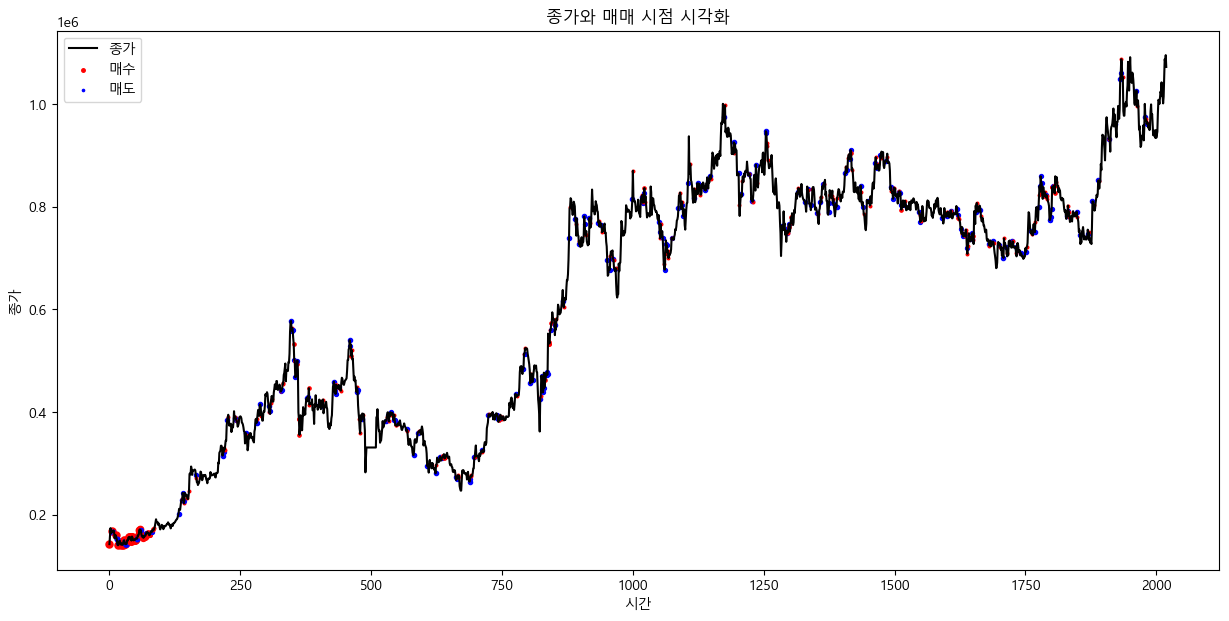

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# Plot scatter for actions:
# Filter indices for action 0 and 1
buy_indices = [i for i, a in enumerate(actions) if a == 0]
sell_indices = [i for i, a in enumerate(actions) if a == 1]
buy_units = [units[i] for i in buy_indices]
sell_units = [units[i] for i in sell_indices]

plt.figure(figsize=(15, 7))
plt.plot(df.index, df["Close"], label="종가", color="black")

buy_plotted = False
sell_plotted = False

for i, (act, unit) in enumerate(zip(actions, units)):
    if act == 2 or unit == 0:
        continue

    x = df.index[i]
    y = df["Close"].iloc[i]
    if act == 0:
        label = "매수" if not buy_plotted else None
        plt.scatter(x, y, color="red", s=np.log(unit) * 5, label=label)
        buy_plotted = True
    elif act == 1:
        label = "매도" if not sell_plotted else None
        plt.scatter(x, y, color="blue", s=np.log(unit) * 5, label=label)
        sell_plotted = True

plt.xlabel("시간")
plt.ylabel("종가")
plt.title("종가와 매매 시점 시각화")
plt.legend(prop={"size": 10}, markerscale=0.5)
plt.show()